In [1]:
import matplotlib.pyplot as plt
import numpy as np

from utils import *

# Задание 1

In [2]:
handler = Signal_Handler()
converter = Converter(T = 2)
display = Signal_Display()

In [3]:
def nonlinear_kernel(x, A):
    return A * np.exp(-x ** 2)

In [4]:
def linear_kernel(x, k, b):
    return k * x + b

In [5]:
x, y, dt      = handler.make_signal('rect',  interval = (-4, 4), A = 1, w = converter.w)
x_k1, y_k1, _ = handler.make_signal('other', interval = (-4, 4), func = lambda x: nonlinear_kernel(x, A = 2))
x_k2, y_k2, _ = handler.make_signal('other', interval = (-4, 4), func = lambda x: linear_kernel(x, k = 2, b = 0))

In [6]:
y_conv1 = handler.convolve(y, y_k1, mode = 'same')
y_conv2 = handler.convolve(y, y_k2, mode = 'same')

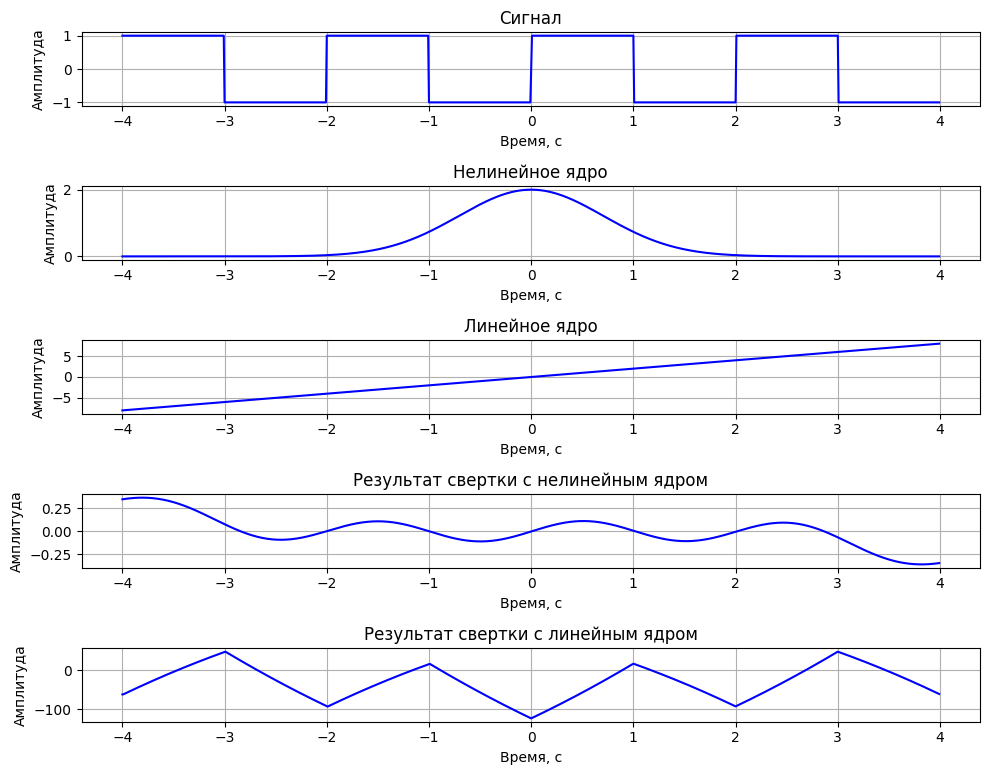

In [7]:
display.clear()

display.make_plot(0, x, y, title = 'Сигнал')
display.make_plot(1, x_k1, y_k1, title = 'Нелинейное ядро')
display.make_plot(2, x_k2, y_k2, title = 'Линейное ядро')
display.make_plot(3, x, y_conv1, title = 'Результат свертки с нелинейным ядром')
display.make_plot(4, x, y_conv2, title = 'Результат свертки с линейным ядром')

display.plot()

# Задание 2

In [8]:
def conv(signal, kernel, mode = 'full'):
    
    res_len = {'full': len(signal) + len(kernel) - 1,
               'same': max(len(signal), len(kernel)),
               'valid': max(len(signal), len(kernel)) - min(len(signal), len(kernel)) + 1}

    conv_res = np.array([
        np.dot(signal[max(0, i) : min(i + len(kernel), len(signal))],
               kernel[max(-i, 0) : len(signal) - i * (len(signal) - len(kernel) < i)]) 
               for i in range(1 - len(kernel), len(signal))
               ])

    if mode == 'full':
        return conv_res
    
    if mode in ['same', 'valid']:
        start_index = int(np.floor((res_len['full'] - res_len[mode]) / 2))
        return conv_res[start_index : start_index + res_len[mode]]

In [9]:
y_conv = handler.convolve(y, y_k1, mode = 'same')

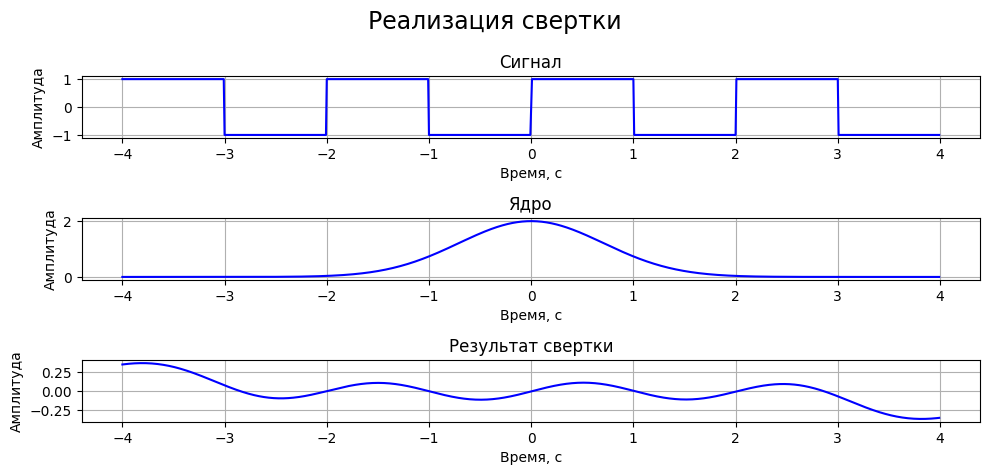

In [10]:
display.clear()

display.make_plot(0, x, y, title = 'Сигнал')
display.make_plot(1, x_k1, y_k1, title = 'Ядро')
display.make_plot(2, x, y_conv, title = 'Результат свертки')

display.plot(title = 'Реализация свертки')

# Задание 3

In [11]:
def fft_conv(signal, kernel, mode = 'full'):
    handler = Signal_Handler()

    res_len = {'full': len(signal) + len(kernel) - 1,
               'same': max(len(signal), len(kernel)),
               'valid': max(len(signal), len(kernel)) - min(len(signal), len(kernel)) + 1}

    signal = np.pad(signal, (0, res_len['full'] - len(signal)), 'constant')
    kernel = np.pad(kernel, (0, res_len['full'] - len(kernel)), 'constant')
        
    _, yf_s = handler.find_spectrum(signal, 1)
    _, yf_k = handler.find_spectrum(kernel, 1)

    conv_res = ifft(yf_s * yf_k)

    if mode == 'full':
        return conv_res
    
    if mode in ['same', 'valid']:
        start_index = int(np.floor((res_len['full'] - res_len[mode]) / 2))
        return conv_res[start_index : start_index + res_len[mode]]

In [12]:
y_conv = handler.convolve(y, y_k1, mode = 'same')

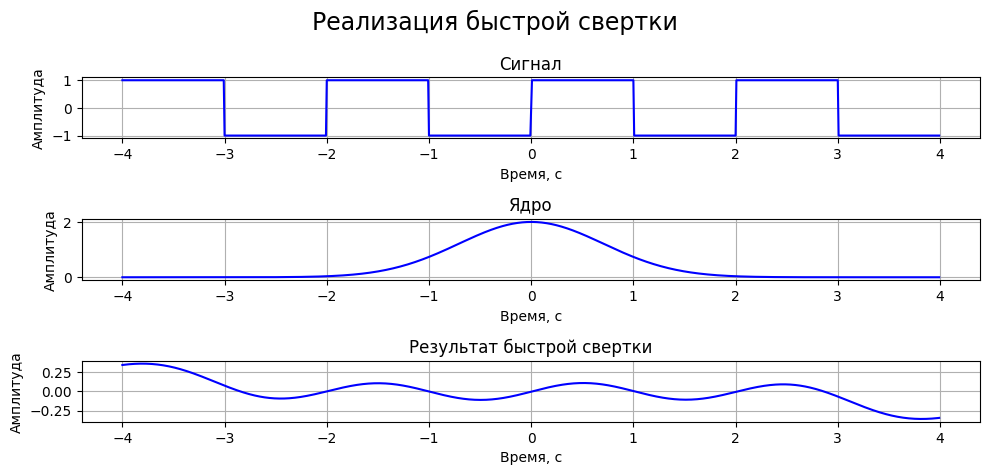

In [13]:
display.clear()

display.make_plot(0, x, y, title = 'Сигнал')
display.make_plot(1, x_k1, y_k1, title = 'Ядро')
display.make_plot(2, x, y_conv, title = 'Результат быстрой свертки')

display.plot(title = 'Реализация быстрой свертки')

# Задание 4

In [14]:
def pad_signal(xfft, y_k, interval):

    yfft = np.zeros_like(xfft)
    yfft[(xfft >= interval[0]) & (xfft < interval[1])] = y_k

    return yfft

In [15]:
def Gaussian_kernel(x, p, FWHM):
    s = FWHM * (2 * np.pi - 1) / (4 * np.pi)
    return np.exp(-0.5 * ((x - p) / s) ** 2)

In [16]:
x_k, y_k, _ = handler.make_signal('other', interval = (0, 4), sample_rate = int(4 * dt * 1000), 
                                  func = lambda X: Gaussian_kernel(X, p = 2, FWHM = 1))

x_f, y_f = handler.find_spectrum(y, dt)

In [17]:
yf_k = pad_signal(x_f, y_k, (0, 4))
yf_conv = yf_k * y_f
y_conv = handler.from_spectrum(yf_conv)

c:\Users\Sanya\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


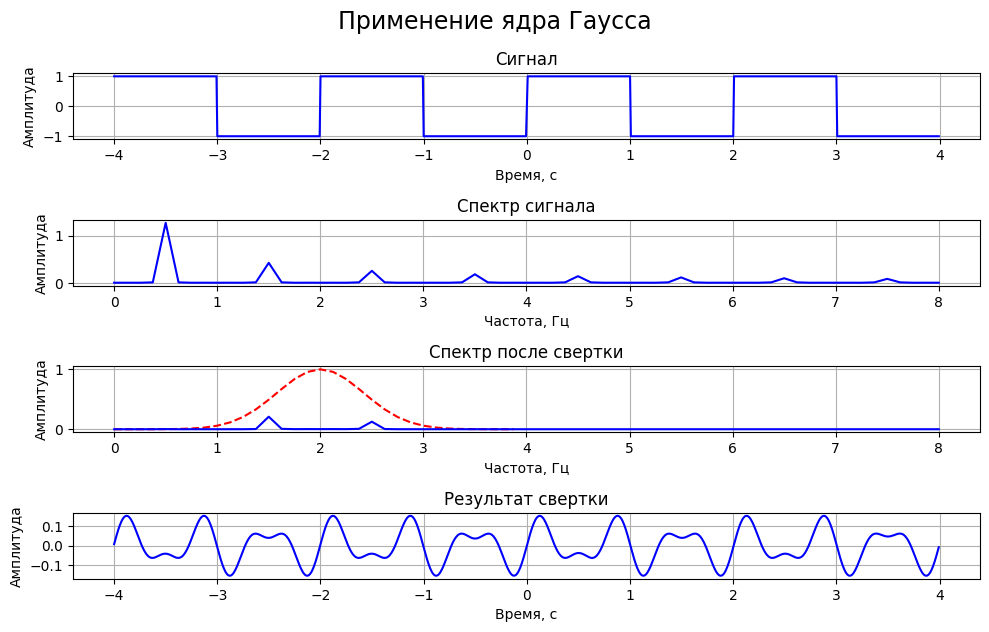

In [18]:
display.clear()

display.make_plot(0, x, y, title = 'Сигнал')
display.make_plot(1, x_f, y_f, title = 'Спектр сигнала', is_spectrum = True, interval = (0, 8))
display.make_plot(2, x_k, y_k, is_spectrum = True, normalize = False, linestyle = '--', color = 'red')
display.make_plot(2, x_f, yf_conv, title = 'Спектр после свертки', is_spectrum = True, interval = (0, 8))
display.make_plot(3, x, y_conv, title = 'Результат свертки')

display.plot(title = 'Применение ядра Гаусса')

# Задание 5

### Свертка в частотной области

In [19]:
x_k, y_k, _ = handler.make_signal('other', interval = (1, 5), sample_rate = int(4 * dt * 1000), 
                                  func = lambda X: Gaussian_kernel(X, p = 3, FWHM = 1))

x_f, y_f = handler.find_spectrum(y, dt)

In [20]:
yf_k = pad_signal(x_f, y_k, (1, 5))

In [21]:
yf_conv = yf_k * y_f
y_conv = handler.from_spectrum(yf_conv)

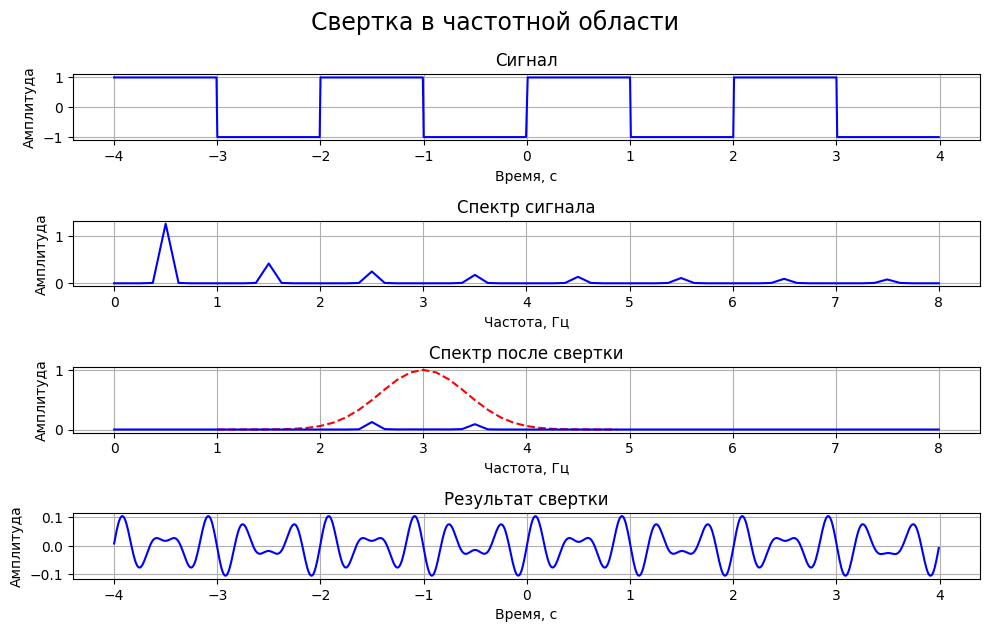

In [22]:
display.clear()

display.make_plot(0, x, y, title = 'Сигнал')
display.make_plot(1, x_f, y_f, title = 'Спектр сигнала', is_spectrum = True, interval = (0, 8))
display.make_plot(2, x_k, y_k, is_spectrum = True, normalize = False, color = 'red', linestyle = '--')
display.make_plot(2, x_f, yf_conv, title = 'Спектр после свертки', is_spectrum = True, interval = (0, 8))
display.make_plot(3, x, y_conv, title = 'Результат свертки')

display.plot(title = 'Свертка в частотной области')

### Узкополосный фильтр через свертку

In [23]:
x, y, dt = handler.make_signal('cos', interval = (0, 0.1), A = 1, w = Converter(f = [50, 250, 450]).w)

x_k, y_k, _ = handler.make_signal('other', interval = (40, 460), sample_rate = int(420 * dt * 1000), 
                                  func = lambda X: Gaussian_kernel(X, p = 250, FWHM = 250))

In [24]:
x_f, y_f = handler.find_spectrum(y, dt)

In [25]:
yf_k = pad_signal(x_f, y_k, (40, 450))

In [26]:
yf_conv = yf_k * y_f
y_conv = handler.from_spectrum(yf_conv)

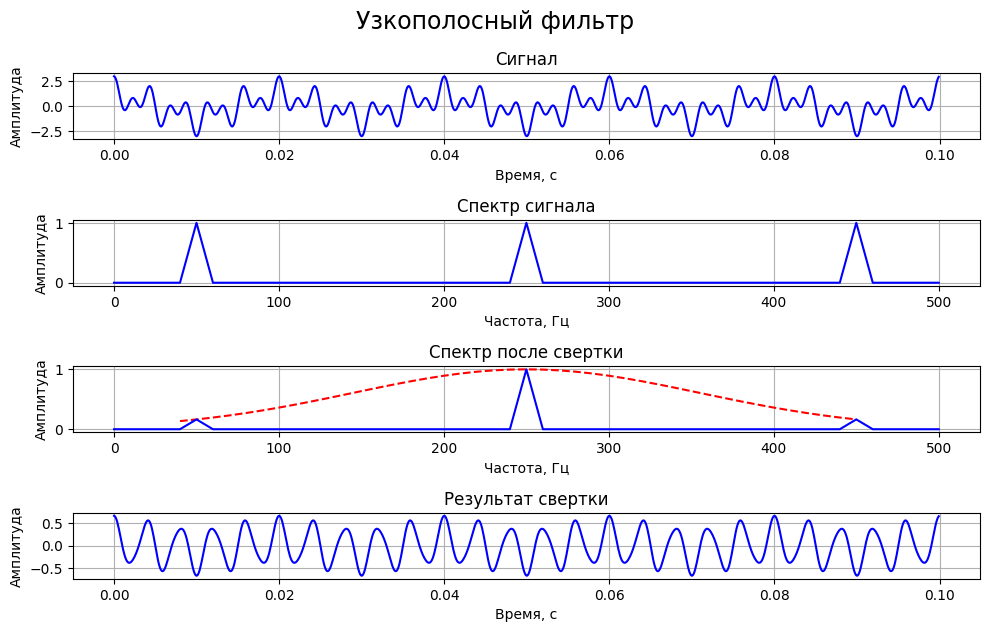

In [27]:
display.clear()

display.make_plot(0, x, y, title = 'Сигнал')
display.make_plot(1, x_f, y_f, title = 'Спектр сигнала', is_spectrum = True, interval = (0, 500))
display.make_plot(2, x_k, y_k, is_spectrum = True, normalize = False, color = 'red', linestyle = '--')
display.make_plot(2, x_f, yf_conv, title = 'Спектр после свертки', is_spectrum = True, interval = (0, 500))
display.make_plot(3, x, y_conv, title = 'Результат свертки')

display.plot(title = 'Узкополосный фильтр')

### ФНЧ через свертку

In [28]:
x, y, dt = handler.make_signal('cos', interval = (0, 0.1), A = 1, w = Converter(f = [50, 250, 450]).w)

x_k, y_k, _ = handler.make_signal('other', interval = (0, 400), sample_rate = int(400 * dt * 1000), 
                                  func = lambda X: Gaussian_kernel(X, p = 150, FWHM = 150))

In [29]:
x_f, y_f = handler.find_spectrum(y, dt)

In [30]:
yf_k = pad_signal(x_f, y_k, (0, 400))
yf_conv = yf_k * y_f
y_conv = handler.from_spectrum(yf_conv)

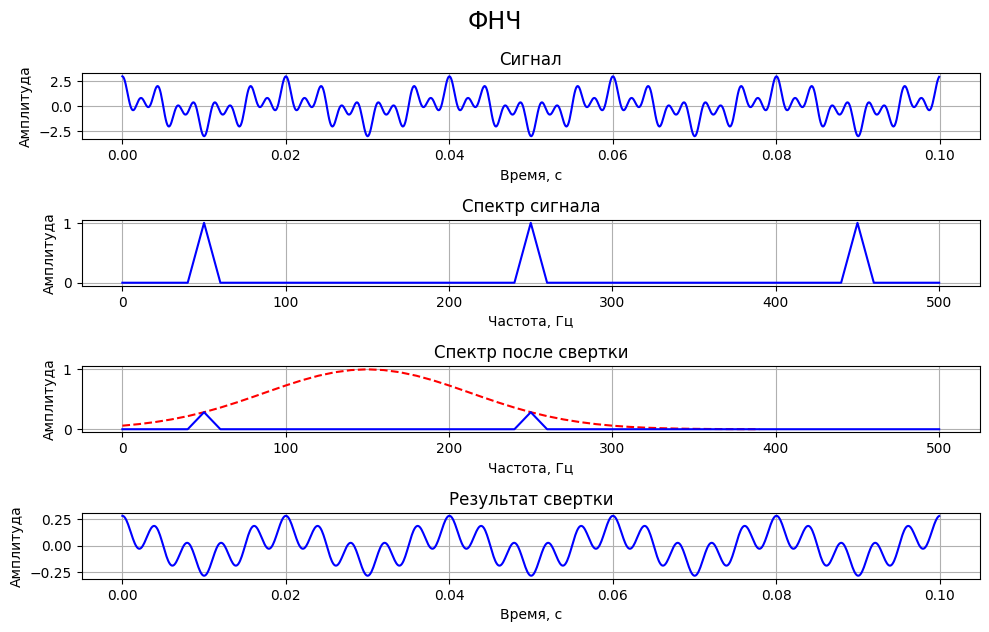

In [31]:
display.clear()

display.make_plot(0, x, y, title = 'Сигнал')
display.make_plot(1, x_f, y_f, title = 'Спектр сигнала', is_spectrum = True, interval = (0, 500))
display.make_plot(2, x_k, y_k, is_spectrum = True, normalize = False, color = 'red', linestyle = '--')
display.make_plot(2, x_f, yf_conv, title = 'Спектр после свертки', is_spectrum = True, interval = (0, 500))
display.make_plot(3, x, y_conv, title = 'Результат свертки')

display.plot(title = 'ФНЧ')

# Задание 6

In [32]:
def Planck_taper_window(X, eps):

    k = np.arange(X.size)
    N = X.size

    za = lambda t: eps * (N - 1) * (1 / t + 1 / (t - eps * (N - 1)))
    zb = lambda t: eps * (N - 1) * (1 / (N - 1 - t) + 1 / ((1 - eps) * (N - 1) - t))

    mask1 = (k > 0) & (k < eps * (N - 1))
    mask2 = (k >= eps * (N - 1)) & (k <= (1 - eps) * (N - 1))
    mask3 = (k > (1 - eps) * (N - 1)) & (k < (N - 1))
    mask4 = (k == 0) | (k == N - 1)

    k[mask1] = 1 / (np.exp(za(k[mask1])) + 1)
    k[mask2] = 1
    k[mask3] = 1 / (np.exp(zb(k[mask1])) + 1)
    k[mask4] = 0

    return k

In [33]:
x, y, dt = handler.make_signal('cos', interval = (0, 0.1), A = 1, w = Converter(f = [50, 250, 450]).w)

x_k, y_k, _ = handler.make_signal('other', interval = (200, 300), sample_rate = int(100 * dt * 1000), 
                                  func = lambda X: Planck_taper_window(X, eps = 0.2))

In [34]:
x_f, y_f = handler.find_spectrum(y, dt)

In [35]:
yf_k = pad_signal(x_f, y_k, (200, 300))
yf_conv = y_f * yf_k
y_conv = handler.from_spectrum(yf_conv)

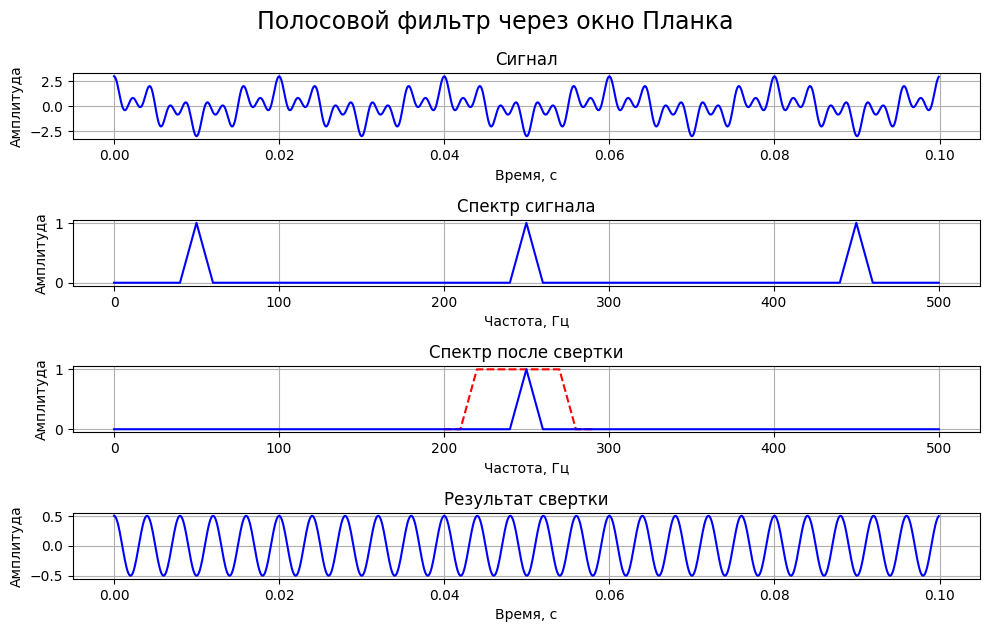

In [36]:
display.clear()

display.make_plot(0, x, y, title = 'Сигнал')
display.make_plot(1, x_f, y_f, title = 'Спектр сигнала', is_spectrum = True, interval = (0, 500))
display.make_plot(2, x_k, y_k, is_spectrum = True, normalize = False, color = 'red', linestyle = '--')
display.make_plot(2, x_f, yf_conv, title = 'Спектр после свертки', is_spectrum = True, interval = (0, 500))
display.make_plot(3, x, y_conv, title = 'Результат свертки')

display.plot(title = 'Полосовой фильтр через окно Планка')

# Задание 7

In [37]:
x, y, dt = handler.make_signal('cos', interval = (0, 0.1), A = 1, w = Converter(f = [50, 250, 450]).w)

x_k1, y_k1, _ = handler.make_signal('other', interval = (200, 300), sample_rate = int(100 * dt * 1000), 
                                    func = lambda X: Planck_taper_window(X, eps = 0.3))

x_k2, y_k2, _ = handler.make_signal('other', interval = (200, 300), sample_rate = int(100 * dt * 1000), 
                                    func = lambda X: Gaussian_kernel(X, p = 250, FWHM = 50))

In [38]:
y += np.random.normal(0, 2, y.size)

In [39]:
x_f, y_f = handler.find_spectrum(y, dt)

In [40]:
yf_k1 = pad_signal(x_f, y_k1, (200, 300))
yf_k2 = pad_signal(x_f, y_k2, (200, 300))

In [41]:
yf_conv1 = y_f * yf_k1
yf_conv2 = y_f * yf_k2

y_conv1 = handler.from_spectrum(yf_conv1)
y_conv2 = handler.from_spectrum(yf_conv2)

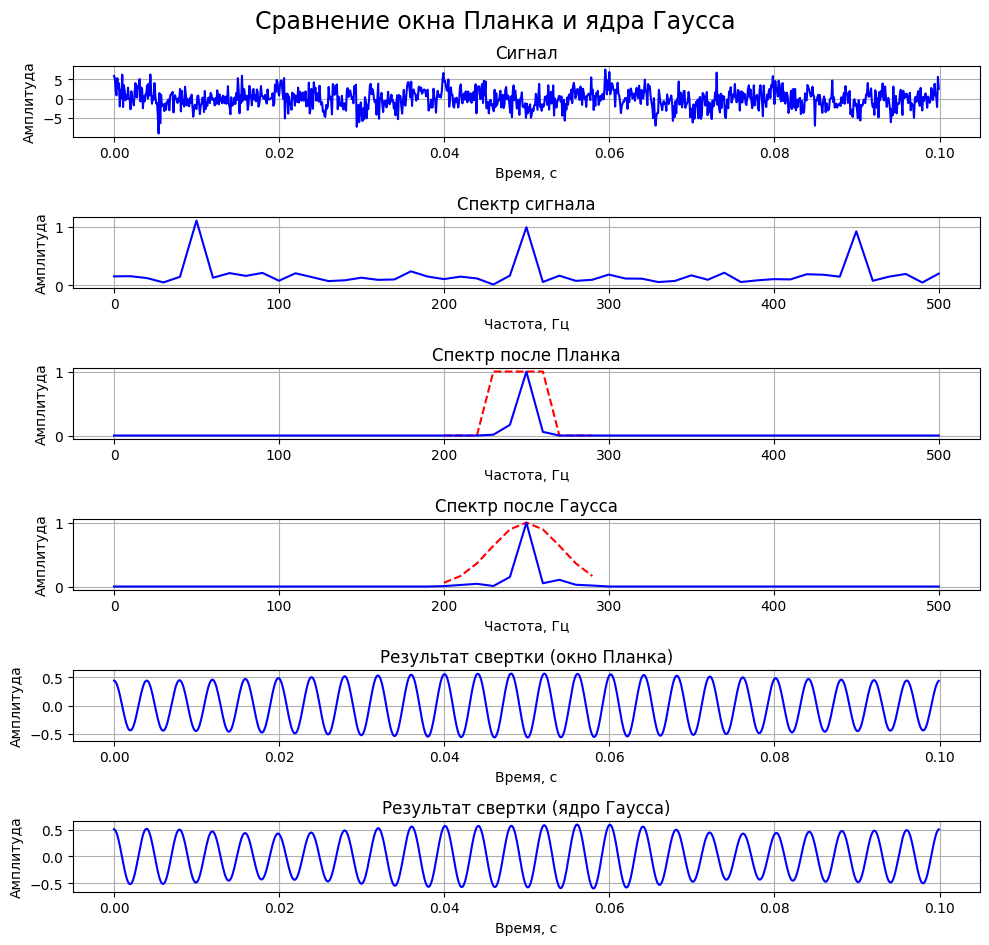

In [42]:
display.clear()

display.make_plot(0, x, y, title = 'Сигнал')
display.make_plot(1, x_f, y_f, title = 'Спектр сигнала', is_spectrum = True, interval = (0, 500))
display.make_plot(2, x_k1, y_k1, is_spectrum = True, normalize = False, color = 'red', linestyle = '--')
display.make_plot(2, x_f, yf_conv1, title = 'Спектр после Планка', is_spectrum = True, interval = (0, 500))
display.make_plot(3, x_k2, y_k2, is_spectrum = True, normalize = False, color = 'red', linestyle = '--')
display.make_plot(3, x_f, yf_conv2, title = 'Спектр после Гаусса', is_spectrum = True, interval = (0, 500))
display.make_plot(4, x, y_conv1, title = 'Результат свертки (окно Планка)')
display.make_plot(5, x, y_conv2, title = 'Результат свертки (ядро Гаусса)')

display.plot(title = 'Сравнение окна Планка и ядра Гаусса')